# Compare neighbourhoods

In [52]:
library(SingleCellExperiment)
library(miloR)
library(DelayedArray)
library(Matrix)
library(ggraph)
library(igraph)
library(viridis)
source("../data-in/rabbit/load_rabbit.R")
source("../scrabbitr/R/plot_utils.R") #temp

Loading required package: viridisLite



## Load data

In [2]:
# Load data
r_data <- loadRabbitData()
r_data

class: SingleCellExperiment 
dim: 30725 146133 
metadata(0):
assays(2): counts logcounts
rownames(30725): ENSOCUG00000014251 ENSOCUG00000005054 ...
  ENSG00000175602 ENSG00000172324
rowData names(1): V1
colnames(146133): cell_1 cell_2 ... cell_172994 cell_172995
colData names(14): cell barcode ... sizeFactor celltype
reducedDimNames(3): UMAP TSNE PCA
altExpNames(0):

In [3]:
reducedDim(r_data,"PCA") <- as.matrix(reducedDim(r_data,"PCA"))

In [25]:
m_data <- readRDS("../data-in/mouse/integrated_sce.rds")
m_data


class: SingleCellExperiment 
dim: 23972 430339 
metadata(0):
assays(2): counts logcounts
rownames(23972): ENSMUSG00000001138 ENSMUSG00000001143 ...
  ENSMUSG00000108929 ENSMUSG00000109022
rowData names(0):
colnames(430339): cell_1 cell_2 ... ext_cell_351871 ext_cell_351872
colData names(0):
reducedDimNames(0):
altExpNames(0):

In [26]:
m_pcs <- readRDS("../data-in/mouse/integrated_corrected_pcs.rds")
reducedDim(m_data,"PCA") <- as.matrix(m_pcs)

In [27]:
m_meta <- read.table("../data-in/mouse/meta.tsv",sep="\t")
m_data$celltype <- m_meta$celltype.clustering

In [28]:
m_meta2 <- readRDS("../data-in/mouse/integrated_metadata.rds")
reducedDim(m_data,"UMAP") <- m_meta2[,c("BBKNN_UMAP1","BBKNN_UMAP2")]

In [28]:
orthologs <- read.table("../data-in/orthologs.tsv",sep="\t")
orthologs[1:5,]

,ref,query
,<chr>,<chr>
ENSOCUG00000000006,ENSOCUG00000000006,ENSMUSG00000026102
ENSOCUG00000000007,ENSOCUG00000000007,ENSMUSG00000028480
ENSOCUG00000000008,ENSOCUG00000000008,ENSMUSG00000070999
ENSOCUG00000000009,ENSOCUG00000000009,ENSMUSG00000028478
ENSOCUG00000000010,ENSOCUG00000000010,ENSMUSG00000028479


## Compute neighbourhoods

In [4]:
# Compute rabbit neighbourhoods
r_milo <- Milo(r_data)
r_milo <- buildGraph(r_milo, k=30, d=50, reduced.dim="PCA")
r_milo <- makeNhoods(r_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")


Constructing kNN graph with k:30

Checking valid object



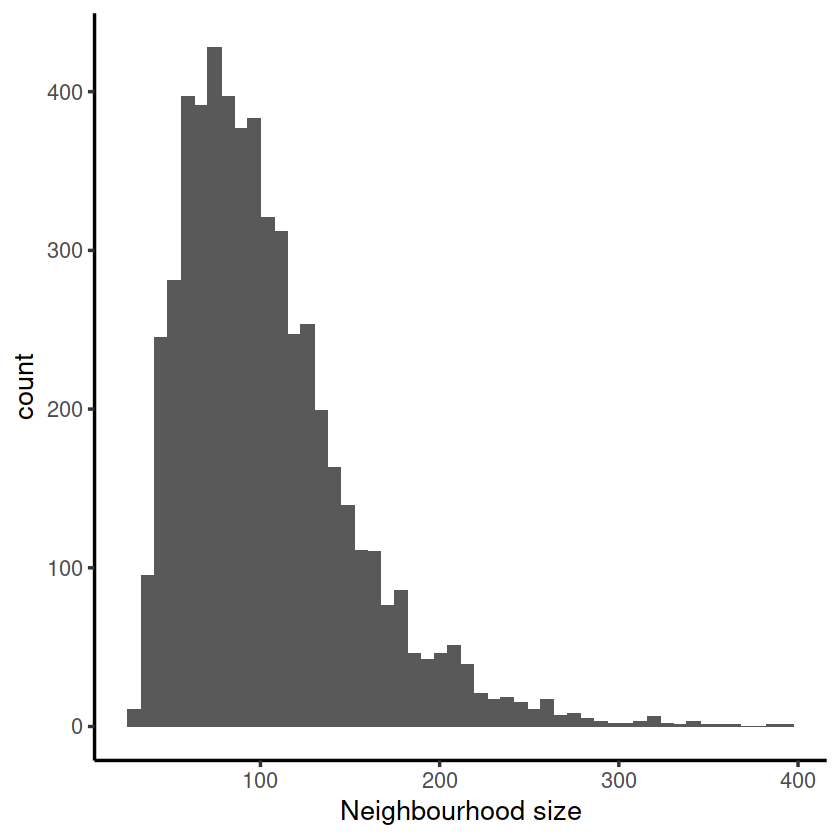

In [38]:
plotNhoodSizeHist(r_milo)

Warning message in plotNhoodGraph(r_milo):
“Coercing layout to matrix format”


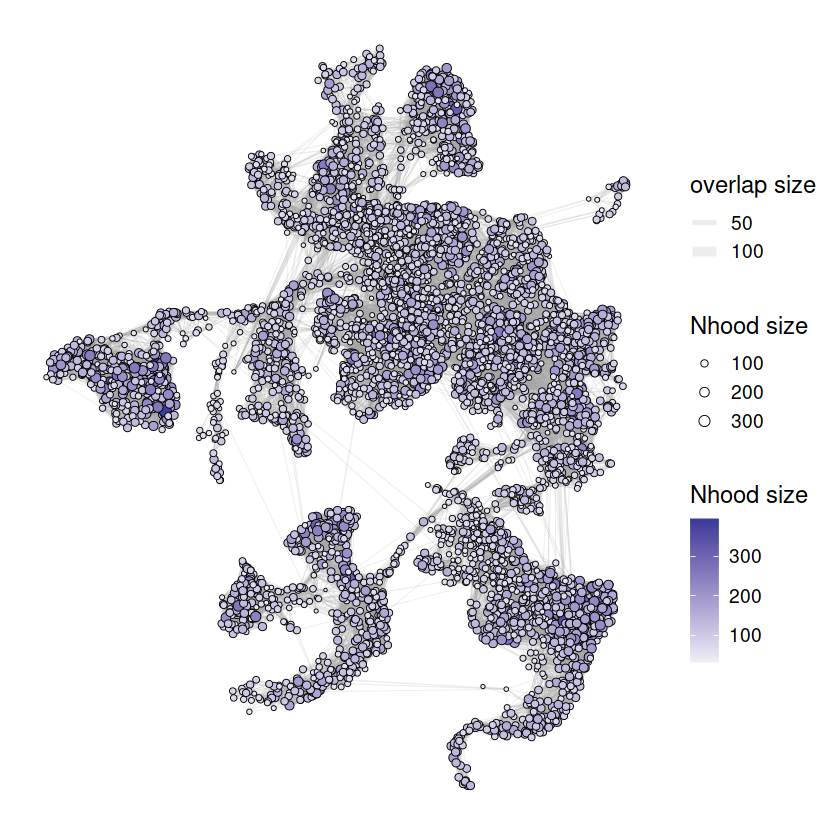

In [5]:
r_milo <- buildNhoodGraph(r_milo)
plotNhoodGraph(r_milo)

In [7]:
writeMM(r_milo@nhoods,"../data-out/compare_neighbourhoods/r_nhoods.mtx")
saveRDS(r_milo,"../data-out/compare_neighbourhoods/r_milo.rds")

NULL

In [29]:
# Compute mouse neighbourhoods
m_milo <- Milo(m_data)
m_milo <- buildGraph(m_milo, k=30, d=50, reduced.dim="PCA")
m_milo <- makeNhoods(m_milo, prop=0.05, k=30, d=50,refined=T, reduced_dims="PCA")

Constructing kNN graph with k:30

Checking valid object



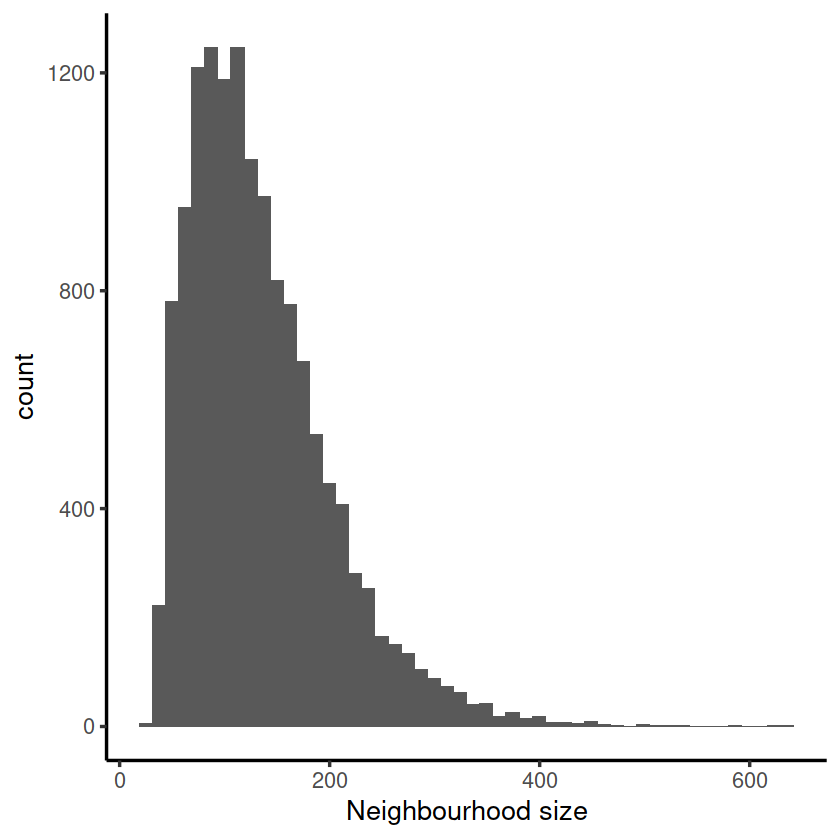

In [30]:
plotNhoodSizeHist(m_milo)

Warning message in plotNhoodGraph(m_milo):
“Coercing layout to matrix format”


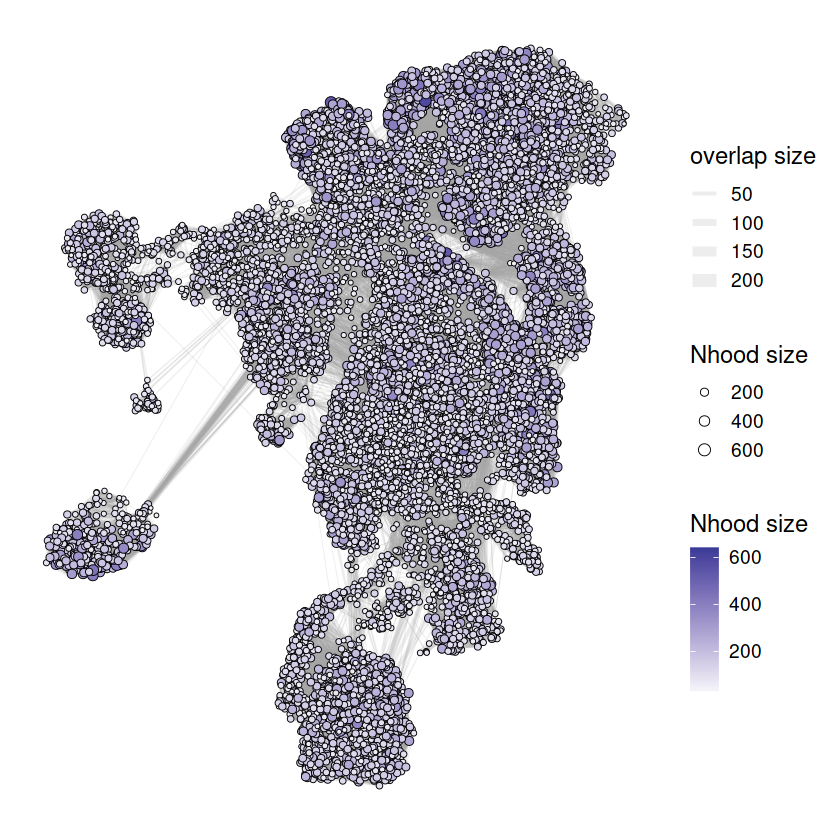

In [33]:
m_milo <- buildNhoodGraph(m_milo)
plotNhoodGraph(m_milo)

In [6]:
m_milo <- readRDS("../data-out/compare_neighbourhoods/m_milo.rds")
#m_nhoods <- readRDS("../data-out/compare_neighbourhoods/m_nhoods.rds")
#saveRDS(m_milo,"../data-out/compare_neighbourhoods/m_milo.rds")
#saveRDS(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.rds")
#writeMM(m_milo@nhoods,"../data-out/compare_neighbourhoods/m_nhoods.mtx")

## Plot similarity

In [9]:
# Load correlation
nhood_sim = fread("../data-out/compare_neighbourhoods/gspec_cor.tsv", sep="\t",data.table=F)
colnames(nhood_sim) <- vertex_attr(nhoodGraph(m_milo))$name
rownames(nhood_sim) <- vertex_attr(nhoodGraph(r_milo))$name

In [10]:
nhood_sim[1:5,1:5]

,247238,14403,203858,232515,358972
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
57511,0.7701123,0.4276645,0.6810359,0.6825668,0.6590744
104077,0.7368739,0.4418572,0.7697021,0.7815469,0.7464834
30659,0.6408942,0.5090445,0.6700311,0.6305781,0.6520038
19736,0.4544493,0.6724311,0.4549100,0.4362524,0.4562063
73244,0.6944852,0.4734406,0.7321929,0.6960690,0.7256595


In [20]:
dim(nhood_sim)

[1]  5253 14034

In [21]:
5253 + 14034

[1] 19287

In [11]:
# For each nhood get nhood with maximum similarity in other species
r_maxsim <- apply(nhood_sim,1,FUN=which.max)
m_maxsim <- apply(nhood_sim,2,FUN=which.max)

In [25]:
r_maxsim[1:5]

57511 104077  30659  19736  73244 
  9073    157   7432   4921   2394

In [39]:
# Reshape nhood similarities 
df_sim = reshape2::melt(as.matrix(nhood_sim))
colnames(df_sim) <- c("r_nhood", "m_nhood", "sim")
df_sim[1:5,]

,r_nhood,m_nhood,sim
,<int>,<int>,<dbl>
1,57511,247238,0.7701123
2,104077,247238,0.7368739
3,30659,247238,0.6408942
4,19736,247238,0.4544493
5,73244,247238,0.6944852


In [19]:
dim(df_sim)

[1] 73720602        3

In [40]:
# For each nhood extract only its closest nhood in the other species
df_sim <- df_sim[order(df_sim$r_nhood, -df_sim$sim), ] 
r_maxNhoods <- df_sim[!duplicated(df_sim$r_nhood),]

df_sim <- df_sim[order(df_sim$m_nhood, -df_sim$sim), ] 
m_maxNhoods <- df_sim[!duplicated(df_sim$m_nhood),]

df_simFilt <- rbind(r_maxNhoods,m_maxNhoods)
dim(df_simFilt)

In [43]:
# Subset neighbourhoods based on colData observation
subsetNhoods <- function(milo, obs, values) {
    milo_graph <- nhoodGraph(milo)
    nhood_ids <- as.numeric(vertex_attr(milo_graph)$name)
    nhood_obs <- colData(milo)[nhood_ids,obs]
    nhood_filt <- as.character(nhood_ids[nhood_obs %in% values])
    return(nhood_filt)
}

In [70]:
r_graph <- nhoodGraph(r_milo)
m_graph <- nhoodGraph(m_milo)

r_nhoodFilt <- subsetNhoods(r_milo, "celltype", c("Allantois","Lateral plate mesoderm", "Epiblast", "Primitive Streak", "Nascent mesoderm"))
m_nhoodFilt <- subsetNhoods(m_milo, "celltype", c("Allantois","Lateral plate mesoderm", "Epiblast", "Primitive Streak", "Nascent mesoderm"))

r_graphFilt <- induced_subgraph(r_graph, r_nhoodFilt)
m_graphFilt <- induced_subgraph(m_graph, m_nhoodFilt)

In [98]:
plotNhoodSim <- function(r_milo, m_milo, df_sim, colour_by, r_graph=NULL, m_graph=NULL, offset=c(10,0),
                        reflect.X=FALSE, reflect.Y = FALSE) {
    

    # Check if subset graph provided
    if(is.null(r_graph)) {
        r_graph <- nhoodGraph(r_milo)
    }
    
    if(is.null(m_graph)) {
        m_graph <- nhoodGraph(m_milo)
    }
    
    
    # Plot rabbit graph
    V(r_graph)$colour_by <- colData(r_milo)[as.numeric(vertex_attr(r_graph)$name), colour_by]
    r_layout <- reducedDim(r_milo, "UMAP")[as.numeric(vertex_attr(r_graph)$name),]

    r_df <- cbind(r_layout, V(r_graph)$colour_by)
    colnames(r_df) <- c("x","y","celltype")

#     p <- ggraph(simplify(r_graph), layout = layout) +
#       geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha=0.2) +
#       geom_node_point(aes(fill = colour_by, size = size), shape=21) +
#       scale_fill_manual(values = celltype_colours, name="") + 
#       scale_edge_width(range = c(0.2,3), name="overlap size") + theme(legend.position="none")
#       #theme_classic(base_size=14) +
#       #theme(axis.line = element_blank(), axis.text = element_blank(),
#        #     axis.ticks = element_blank(), axis.title = element_blank(),
#          #   legend.position="none") 


    # Plot mouse graph
    V(m_graph)$colour_by <- colData(m_milo)[as.numeric(vertex_attr(m_graph)$name), colour_by]
    m_layout <- reducedDim(m_milo, "UMAP")[as.numeric(vertex_attr(m_graph)$name),]
    
    # Add spacing to offset mouse and rabbit umaps
    m_layout[,1] <- m_layout[,1] + offset[1]
    m_layout[,2] <- m_layout[,2] + offset[2]

    if(reflect.X) { m_layout[,1] = -m_layout[,1]}
    if(reflect.Y) {  m_layout[,2] = -m_layout[,2]}

    m_df <- cbind(m_layout, V(m_graph)$colour_by)

    colnames(m_df) <- c("x","y","celltype")

#    p <- p + ggraph(simplify(m_graph), layout = layout) +
#       geom_edge_link0(aes(width = weight), edge_colour = "grey66", edge_alpha=0.2) +
#       geom_node_point(aes(fill = colour_by, size = size), shape=21) +
#       scale_fill_manual(values = celltype_colours, name="") + 
#       scale_edge_width(range = c(0.2,3), name="overlap size") + theme(legend.position="none")
#       #theme_classic(base_size=14) +
#       #theme(axis.line = element_blank(), axis.text = element_blank(),
#       #      axis.ticks = element_blank(), axis.title = element_blank(),
#        #     legend.position="none"
#        #     ) 

    df_plot <- rbind(r_df, m_df)
    p <- ggplot(df_plot,aes(x=x,y=y)) + 
        geom_point(aes(fill=celltype),stroke=0,shape=21) +
        scale_fill_manual(values = celltype_colours, name = "") + theme(legend.position="none")


    # Filter sim data frame to nhoods within graphs provided
    sim_filt <- df_sim[(df_sim$r_nhood %in%  vertex_attr(r_graph)$name) & 
                       (df_sim$m_nhood %in% vertex_attr(m_graph)$name),]
    
    # Filter alignments above some fixed threshold
    #sim_filt <- sim_filt[sim_filt$sim > sim_thresh,]

    # Give each line a unique name
    sim_filt$alignment <- paste0("align_",sim_filt$r_nhood,"_",sim_filt$m_nhood)
    
    # Get rabbit nhood positions
    r_pos <- reducedDim(r_milo, "UMAP")[as.numeric(vertex_attr(r_graph)$name),]
    rownames(r_pos) <- vertex_attr(r_graph)$name
    
    # Get mouse nhood positions    
    m_pos <- reducedDim(m_milo, "UMAP")[as.numeric(vertex_attr(m_graph)$name),]

    # Add offset to mouse nhood positions
    m_pos[,1] <- m_pos[,1] + offset[1]
    m_pos[,2] <- m_pos[,2] + offset[2]


    if(reflect.X) { m_pos[,1] = -m_pos[,1]}
    if(reflect.Y) {  m_pos[,2] = -m_pos[,2]}

    rownames(m_pos) <- vertex_attr(m_graph)$name

    # For each comparison create dataframe with both rabbit and mouse nhood positions
    # linked by alignment name
    r_lines <- sim_filt
    r_lines[,c("x","y")] <- r_pos[as.character(r_lines$r_nhood),]

    m_lines <- sim_filt
    m_lines[, c("x", "y")] <- m_pos[as.character(m_lines$m_nhood),]

    df_lines <- rbind(r_lines, m_lines)

    # Add similarities lines
    p <- p + geom_line(data=df_lines,aes(x=x,y=y, group=alignment,colour=sim),alpha=0.075) +
    scale_colour_viridis()

    p <- p +  theme_classic(base_size=14) +
    theme(axis.line = element_blank(), axis.text = element_blank(),
      axis.ticks = element_blank(), axis.title = element_blank(),
       legend.position="none") 

    return(p)
        
}
    


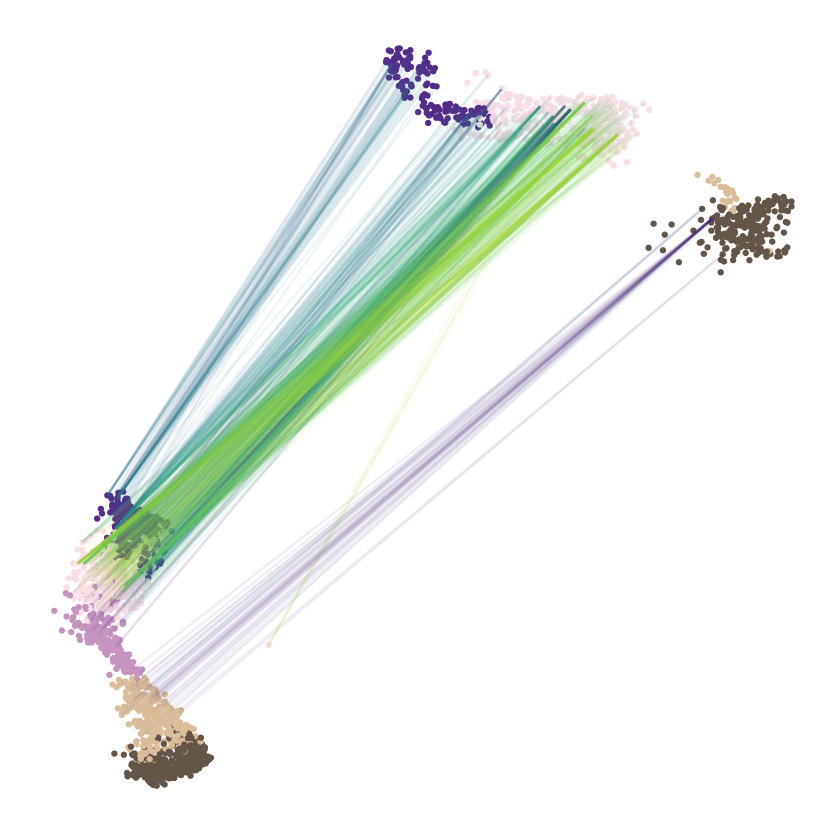

In [99]:
plotNhoodSim(r_milo, m_milo, df_simFilt, "celltype", r_graphFilt, m_graphFilt, offset=c(2,0), reflect.X=TRUE, reflect.Y)